In [78]:
%load_ext autoreload
%autoreload 2

%config InlineBackend.figure_format = "retina"

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# 1. Regression (Linear Model)

In [8]:
from functools import partial

from bayes_opt import BayesianOptimization
import jax.numpy as jnp
import jax.random as jr
import matplotlib.pyplot as plt
import tensorflow_probability.substrates.jax as tfp

from rebayes.extended_kalman_filter.ekf import RebayesNFEKF
import rebayes.utils.callbacks as callbacks
import rebayes.utils.models as models
from rebayes.utils.normalizing_flows import NF_MLP, init_normalizing_flow

tfd = tfp.distributions
MVN = tfd.MultivariateNormalTriL
MVD = tfd.MultivariateNormalDiag

In [3]:
MEAN_VALS = [1.3, 1.0, 1.3, 0.95, 0.6, 0.25, 0.8, 0.5,]
CHANGE_POINTS = [451, 709, 958, 1547, 2147, 2769, 2957,]

def generate_time_series_data(
    key=0,
    n_points=3058,
    change_points=CHANGE_POINTS,
    means=MEAN_VALS,
    variance=0.01
):
    if isinstance(key, int):
        key = jr.PRNGKey(key)
    xs = jnp.arange(n_points)

    change_points = jnp.array([0, *change_points, n_points])
    segment_lengths = jnp.array(
        [change_points[i + 1] - change_points[i] for i in range(len(change_points) - 1)]
    )
    result = jnp.concatenate(
        [means[i]*jnp.ones(segment_lengths[i]) for i in range(len(segment_lengths))]
    )
    noise = jnp.sqrt(variance) * jr.normal(key, result.shape)
    ys = result + noise

    return xs, ys

In [4]:
xs, ys = generate_time_series_data()

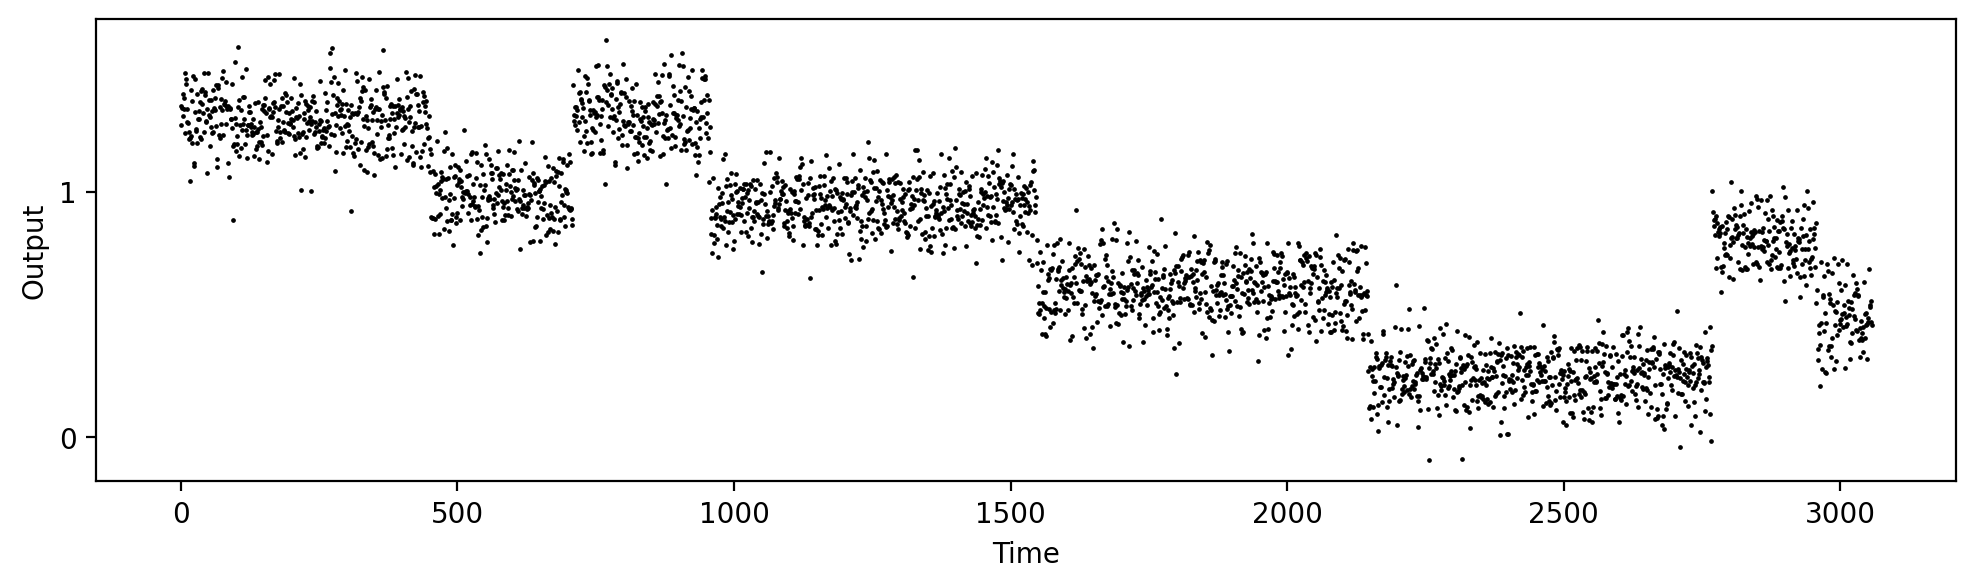

In [5]:
# Plot
fig, ax = plt.subplots(figsize=(12, 3))
plt.scatter(xs, ys, s=0.5, color="black")
ax.set_xlabel("Time")
ax.set_ylabel("Output")
ax.set_yticks([0, 1]);

In [11]:
# Set up NF
init_mean, init_cov = jnp.array([0.0, 0.0]), 0.01 * jnp.eye(2)
nf_model = NF_MLP()
input_dim = len(init_mean)
nfs = init_normalizing_flow(nf_model, input_dim)

## 1.1 Vanilla Kalman Filter

In [37]:
ekf = RebayesNFEKF(
    dynamics_weights_or_function=1.0,
    dynamics_covariance=0.,
    emission_mean_function=lambda w, x: w[0],
    emission_cov_function=lambda w, x: 0.05,
    nf_initial_params=nfs["params"],
    nf_apply_function=nfs["apply_fn"],
    method="fcekf",
    learning_rate=0.0,
)
init_mean, init_cov = jnp.array([0.0, 0.0]), 0.01 * jnp.eye(2)

ekf_kwargs = {
    "agent": ekf,
}

def callback(bel, pred_obs, t, x, y, bel_pred, **kwargs):
    agent = kwargs["agent"]
    y_mean = agent.predict_obs(bel_pred, x)
    y_cov = agent.predict_obs_cov(bel_pred, x)
    log_prob = agent.evaluate_log_prob(bel, x, y)
    
    return y_mean, y_cov, log_prob

ekf_bel, ekf_outputs = ekf.scan(
    init_mean, init_cov, xs, ys, callback=callback, **ekf_kwargs
)

In [38]:
ekf_mean, ekf_var, ekf_log_prob = ekf_outputs
ekf_mean, ekf_var, ekf_log_prob = ekf_mean.ravel(), ekf_var.ravel(), ekf_log_prob.ravel()

# Compute cumulative average
ekf_log_prob = jnp.cumsum(ekf_log_prob) / jnp.arange(1, len(ekf_log_prob) + 1)

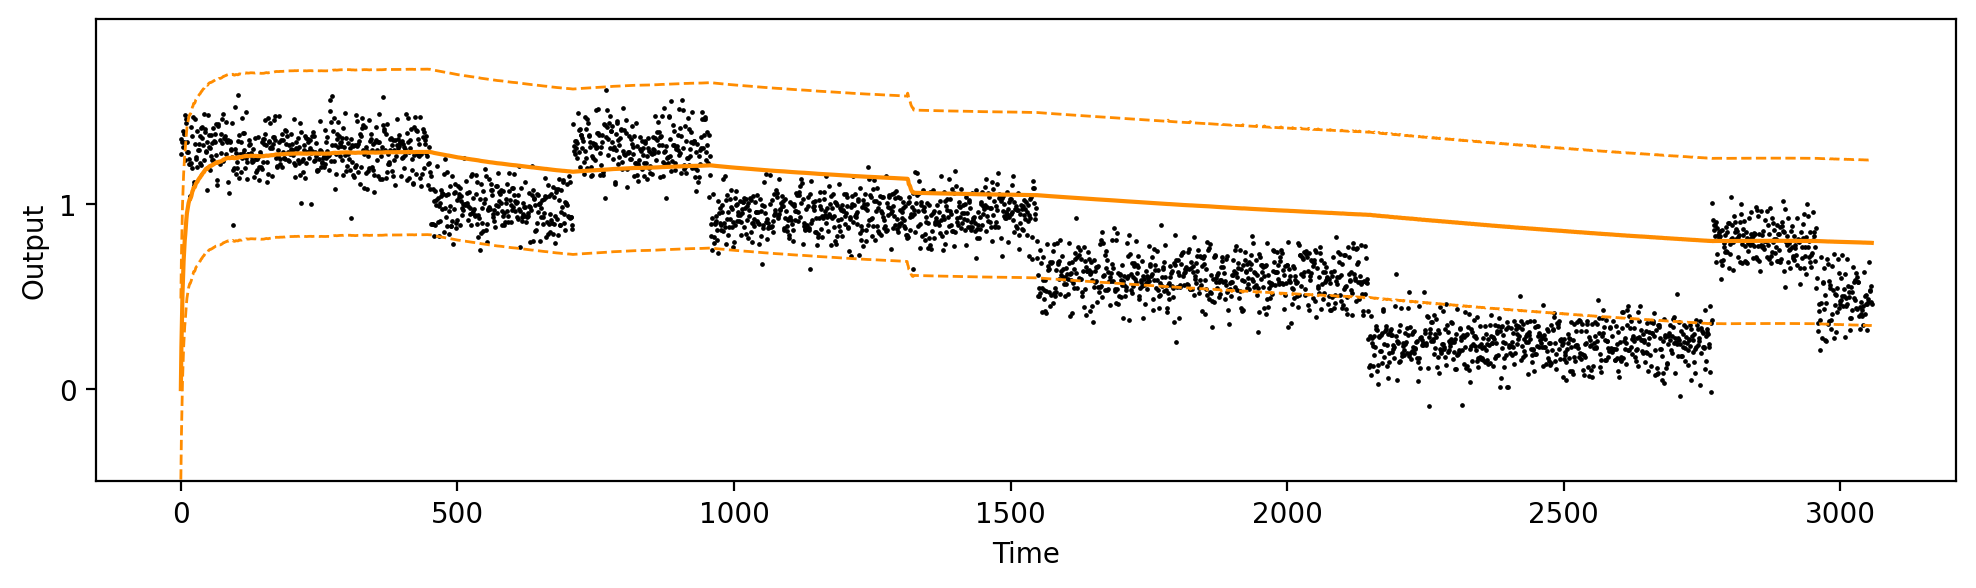

In [39]:
# Plot
fig, ax = plt.subplots(figsize=(12, 3))
plt.scatter(xs, ys, s=0.5, color="black")
plt.plot(xs, ekf_mean, color="darkorange", linewidth=1.5)
plt.plot(xs, ekf_mean + 2*jnp.sqrt(ekf_var), color="darkorange", linewidth=1.0, linestyle="--")
plt.plot(xs, ekf_mean - 2*jnp.sqrt(ekf_var), color="darkorange", linewidth=1.0, linestyle="--")
ax.set_xlabel("Time")
ax.set_ylabel("Output")
ax.set_ylim(-0.5, 2)
ax.set_yticks([0, 1]);

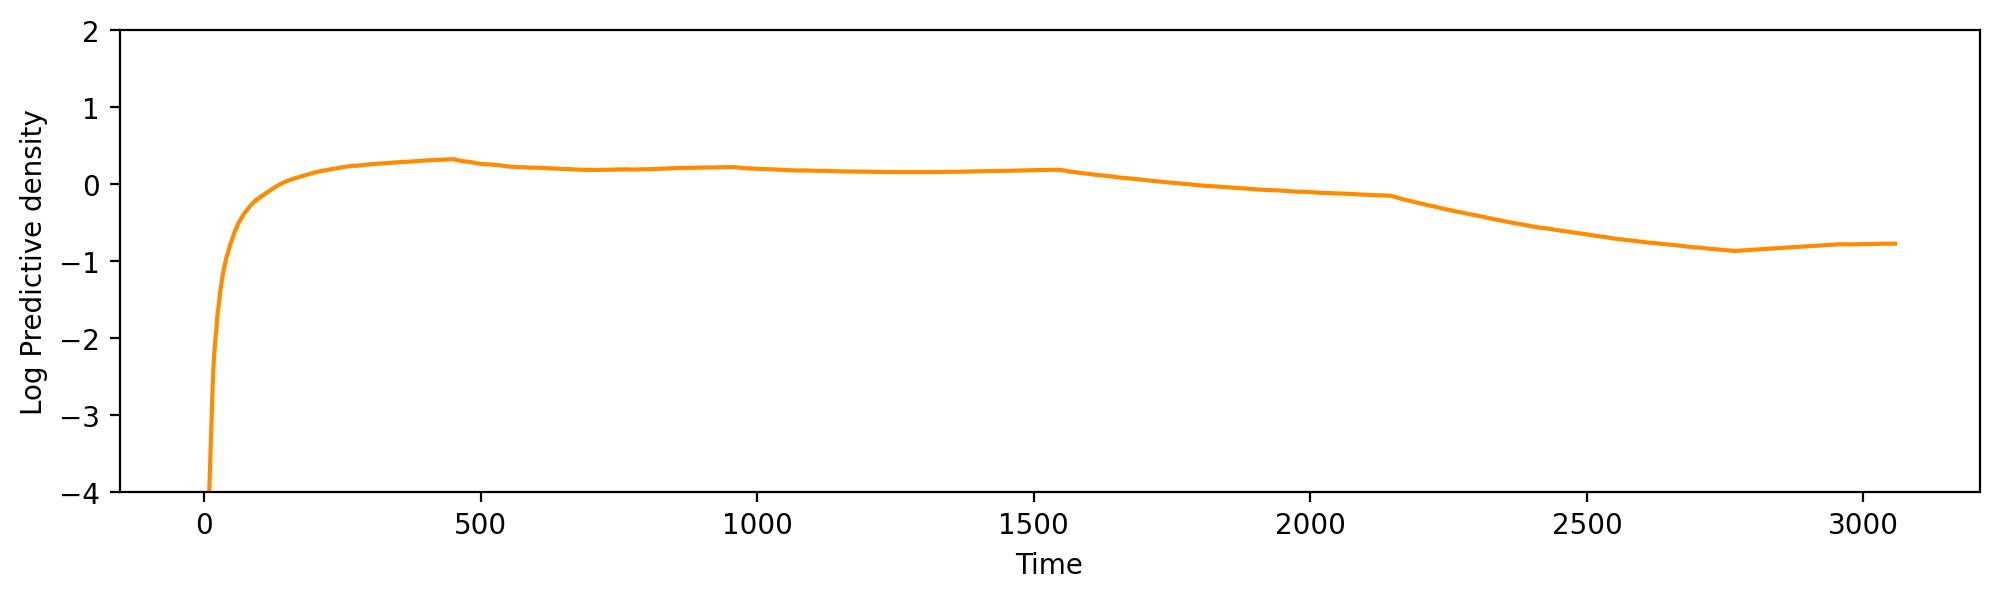

In [40]:
# Plot log prob
fig, ax = plt.subplots(figsize=(12, 3))
plt.plot(xs, ekf_log_prob, color="darkorange", linewidth=1.5)
ax.set_ylim(-4, 2)
ax.set_xlabel("Time")
ax.set_ylabel("Log Predictive density");

## 1.2 NF-KF (lr=1e-6)

In [44]:
ekf = RebayesNFEKF(
    dynamics_weights_or_function=1.0,
    dynamics_covariance=0.,
    emission_mean_function=lambda w, x: w[0],
    emission_cov_function=lambda w, x: 0.05,
    nf_initial_params=nfs["params"],
    nf_apply_function=nfs["apply_fn"],
    method="fcekf",
    learning_rate=1e-6,
)
init_mean, init_cov = jnp.array([0.0, 0.0]), 0.01 * jnp.eye(2)

ekf_kwargs = {
    "agent": ekf,
}

def callback(bel, pred_obs, t, x, y, bel_pred, **kwargs):
    agent = kwargs["agent"]
    y_mean = agent.predict_obs(bel_pred, x)
    y_cov = agent.predict_obs_cov(bel_pred, x)
    log_prob = agent.evaluate_log_prob(bel, x, y)
    
    return y_mean, y_cov, log_prob

ekf_bel, ekf_outputs = ekf.scan(
    init_mean, init_cov, xs, ys, callback=callback, **ekf_kwargs
)

In [45]:
ekf_mean, ekf_var, ekf_log_prob = ekf_outputs
ekf_mean, ekf_var, ekf_log_prob = ekf_mean.ravel(), ekf_var.ravel(), ekf_log_prob.ravel()

# Compute cumulative average
ekf_log_prob = jnp.cumsum(ekf_log_prob) / jnp.arange(1, len(ekf_log_prob) + 1)

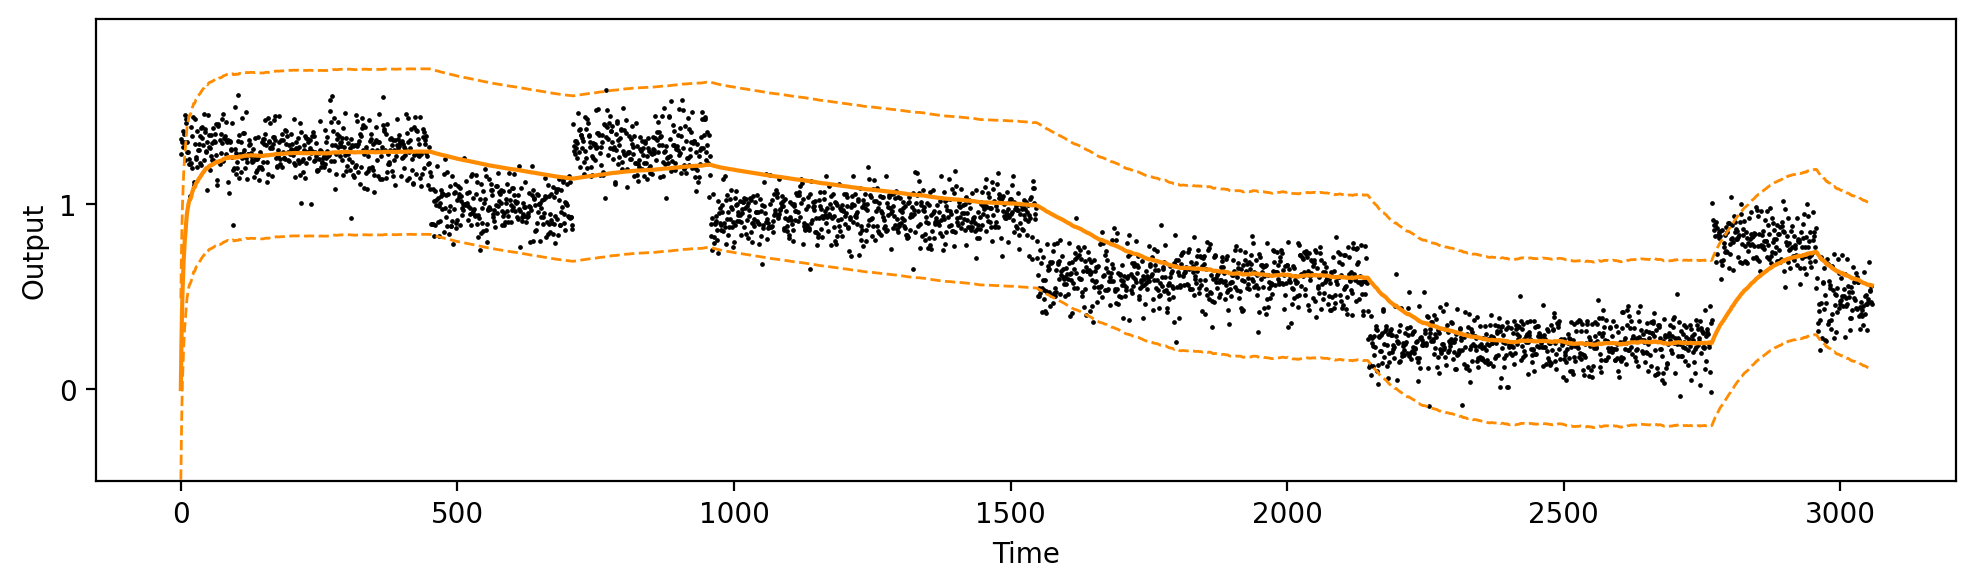

In [46]:
# Plot
fig, ax = plt.subplots(figsize=(12, 3))
plt.scatter(xs, ys, s=0.5, color="black")
plt.plot(xs, ekf_mean, color="darkorange", linewidth=1.5)
plt.plot(xs, ekf_mean + 2*jnp.sqrt(ekf_var), color="darkorange", linewidth=1.0, linestyle="--")
plt.plot(xs, ekf_mean - 2*jnp.sqrt(ekf_var), color="darkorange", linewidth=1.0, linestyle="--")
ax.set_xlabel("Time")
ax.set_ylabel("Output")
ax.set_ylim(-0.5, 2)
ax.set_yticks([0, 1]);

## 1.3 NF-KF (lr=1e-4)

In [47]:
ekf = RebayesNFEKF(
    dynamics_weights_or_function=1.0,
    dynamics_covariance=0.,
    emission_mean_function=lambda w, x: w[0],
    emission_cov_function=lambda w, x: 0.05,
    nf_initial_params=nfs["params"],
    nf_apply_function=nfs["apply_fn"],
    method="fcekf",
    learning_rate=1e-4,
)
init_mean, init_cov = jnp.array([0.0, 0.0]), 0.01 * jnp.eye(2)

ekf_kwargs = {
    "agent": ekf,
}

def callback(bel, pred_obs, t, x, y, bel_pred, **kwargs):
    agent = kwargs["agent"]
    y_mean = agent.predict_obs(bel_pred, x)
    y_cov = agent.predict_obs_cov(bel_pred, x)
    log_prob = agent.evaluate_log_prob(bel, x, y)
    
    return y_mean, y_cov, log_prob

ekf_bel, ekf_outputs = ekf.scan(
    init_mean, init_cov, xs, ys, callback=callback, **ekf_kwargs
)

In [48]:
ekf_mean, ekf_var, ekf_log_prob = ekf_outputs
ekf_mean, ekf_var, ekf_log_prob = ekf_mean.ravel(), ekf_var.ravel(), ekf_log_prob.ravel()

# Compute cumulative average
ekf_log_prob = jnp.cumsum(ekf_log_prob) / jnp.arange(1, len(ekf_log_prob) + 1)

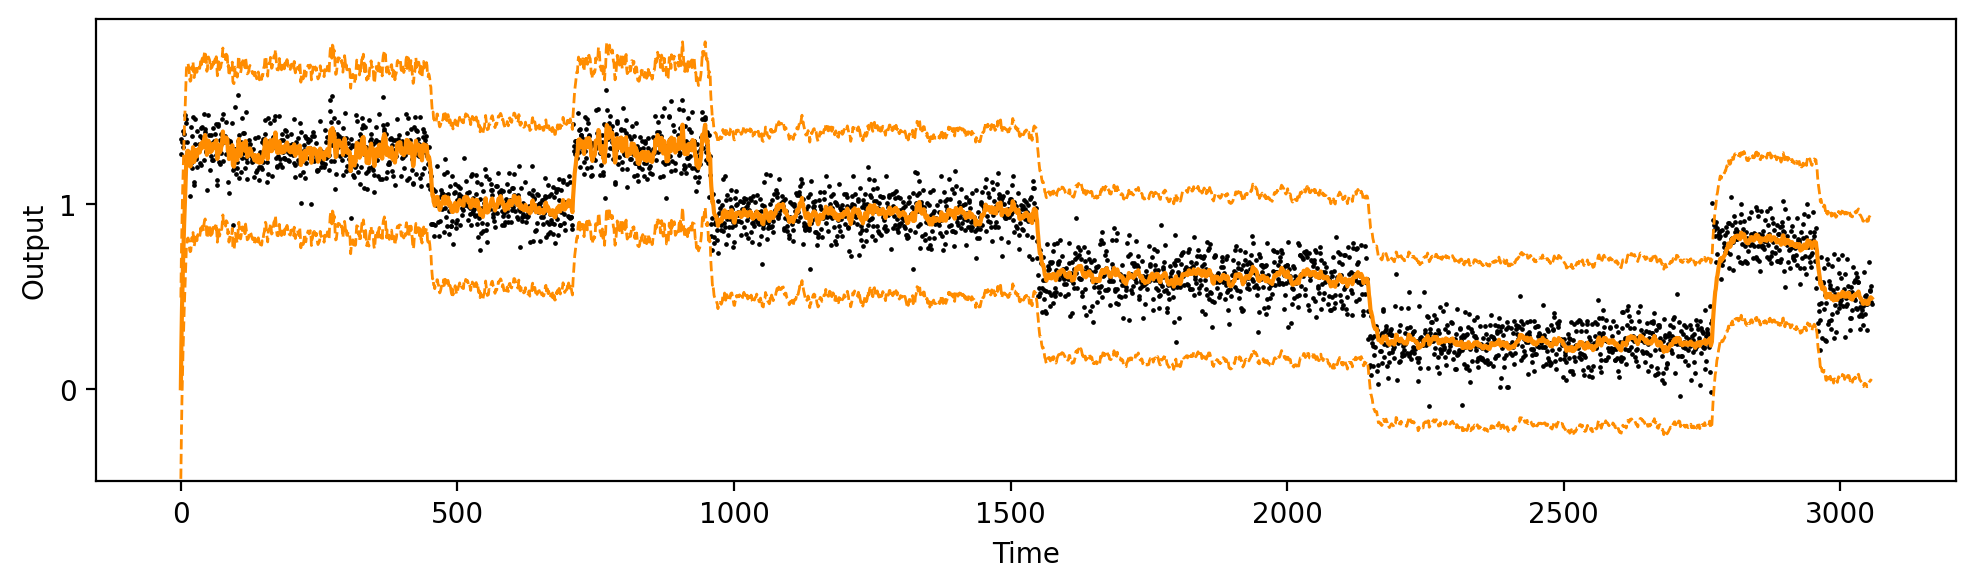

In [49]:
# Plot
fig, ax = plt.subplots(figsize=(12, 3))
plt.scatter(xs, ys, s=0.5, color="black")
plt.plot(xs, ekf_mean, color="darkorange", linewidth=1.5)
plt.plot(xs, ekf_mean + 2*jnp.sqrt(ekf_var), color="darkorange", linewidth=1.0, linestyle="--")
plt.plot(xs, ekf_mean - 2*jnp.sqrt(ekf_var), color="darkorange", linewidth=1.0, linestyle="--")
ax.set_xlabel("Time")
ax.set_ylabel("Output")
ax.set_ylim(-0.5, 2)
ax.set_yticks([0, 1]);

## 1.4 NF-KF (lr=1e-3)

In [50]:
ekf = RebayesNFEKF(
    dynamics_weights_or_function=1.0,
    dynamics_covariance=0.,
    emission_mean_function=lambda w, x: w[0],
    emission_cov_function=lambda w, x: 0.05,
    nf_initial_params=nfs["params"],
    nf_apply_function=nfs["apply_fn"],
    method="fcekf",
    learning_rate=1e-3,
)
init_mean, init_cov = jnp.array([0.0, 0.0]), 0.01 * jnp.eye(2)

ekf_kwargs = {
    "agent": ekf,
}

def callback(bel, pred_obs, t, x, y, bel_pred, **kwargs):
    agent = kwargs["agent"]
    y_mean = agent.predict_obs(bel_pred, x)
    y_cov = agent.predict_obs_cov(bel_pred, x)
    log_prob = agent.evaluate_log_prob(bel, x, y)
    
    return y_mean, y_cov, log_prob

ekf_bel, ekf_outputs = ekf.scan(
    init_mean, init_cov, xs, ys, callback=callback, **ekf_kwargs
)

In [51]:
ekf_mean, ekf_var, ekf_log_prob = ekf_outputs
ekf_mean, ekf_var, ekf_log_prob = ekf_mean.ravel(), ekf_var.ravel(), ekf_log_prob.ravel()

# Compute cumulative average
ekf_log_prob = jnp.cumsum(ekf_log_prob) / jnp.arange(1, len(ekf_log_prob) + 1)

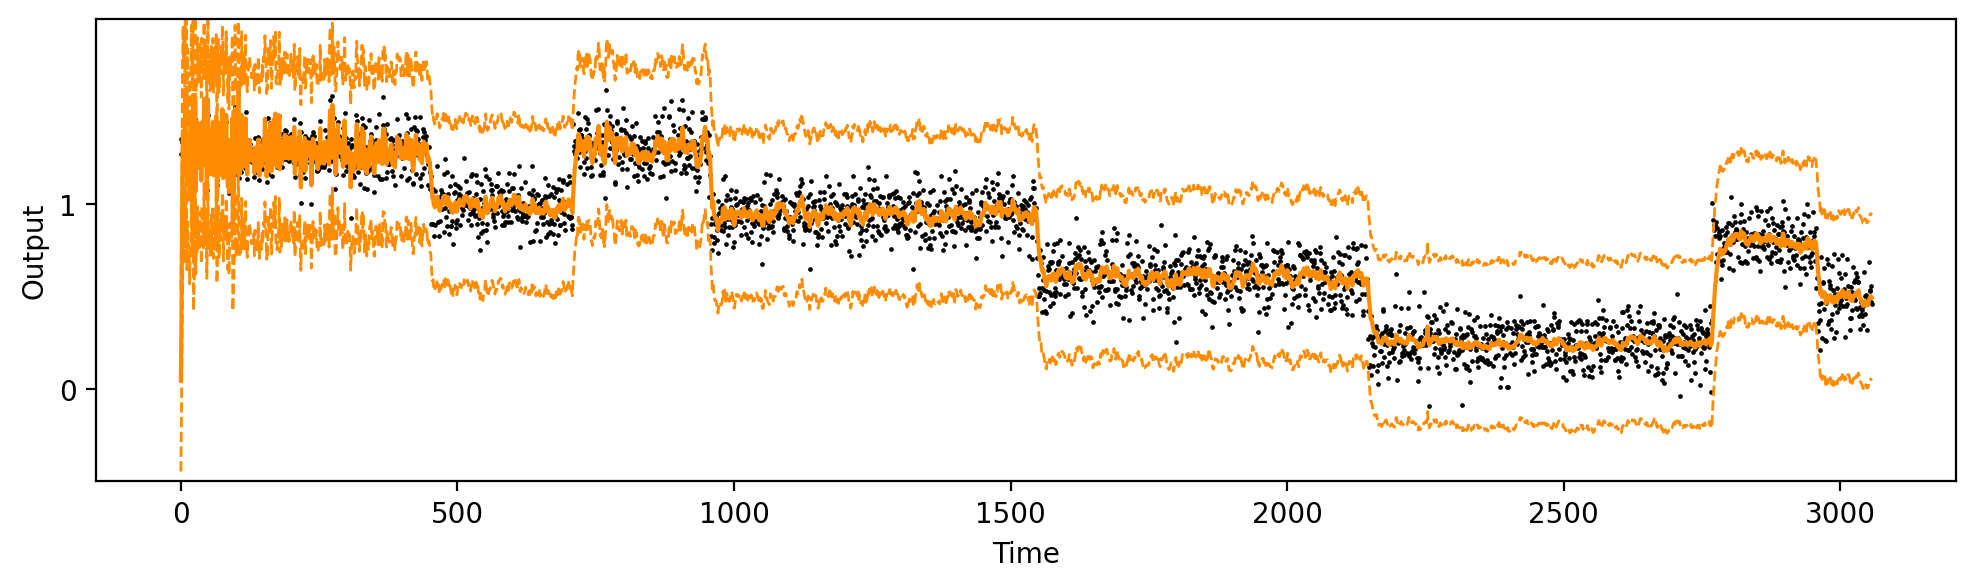

In [52]:
# Plot
fig, ax = plt.subplots(figsize=(12, 3))
plt.scatter(xs, ys, s=0.5, color="black")
plt.plot(xs, ekf_mean, color="darkorange", linewidth=1.5)
plt.plot(xs, ekf_mean + 2*jnp.sqrt(ekf_var), color="darkorange", linewidth=1.0, linestyle="--")
plt.plot(xs, ekf_mean - 2*jnp.sqrt(ekf_var), color="darkorange", linewidth=1.0, linestyle="--")
ax.set_xlabel("Time")
ax.set_ylabel("Output")
ax.set_ylim(-0.5, 2)
ax.set_yticks([0, 1]);

# 2. Regression (In-Between Uncertainty)

In [176]:
from jax import vmap
from jax.flatten_util import ravel_pytree

import seaborn as sns

def generate_dataset(n_train, obs_var, key=42, in_between=False):
    if isinstance(key, int):
        key = jr.PRNGKey(key)
    key, subkey = jr.split(key)

    if in_between:
        mask = jr.bernoulli(key, p=0.5, shape=(n_train,))
        key1, key2, subkey = jr.split(subkey, 3)
        X_train = (-2 * jr.uniform(key1, (n_train,)) - 1) * mask + \
            (2 * jr.uniform(key2, (n_train,)) + 1) * (1. - mask)
    else:
        X_train = jr.normal(key, (n_train,))

    w = jnp.array([-0.6667, -0.6012, -1.0172, -0.7687, 1.4680, -0.1678])
    def f(x, key):
        fx = w @ jnp.power(x, jnp.arange(len(w)))
        fx *= jnp.sin(jnp.pi * x)
        fx *= jnp.exp(-0.5 * (x**2)) / jnp.sqrt(2 * jnp.pi)
        return fx + obs_var * jr.normal(key)

    keys = jr.split(subkey, n_train)
    y_train = vmap(f)(X_train, keys)

    return X_train, y_train

In [177]:
n_train, obs_var = 200, 0.1
X, y = generate_dataset(n_train, obs_var, in_between=True)

idx = jr.permutation(jr.PRNGKey(0), jnp.arange(n_train))
X, y = X[idx], y[idx]

X_grid = jnp.linspace(-4, 4, 150)

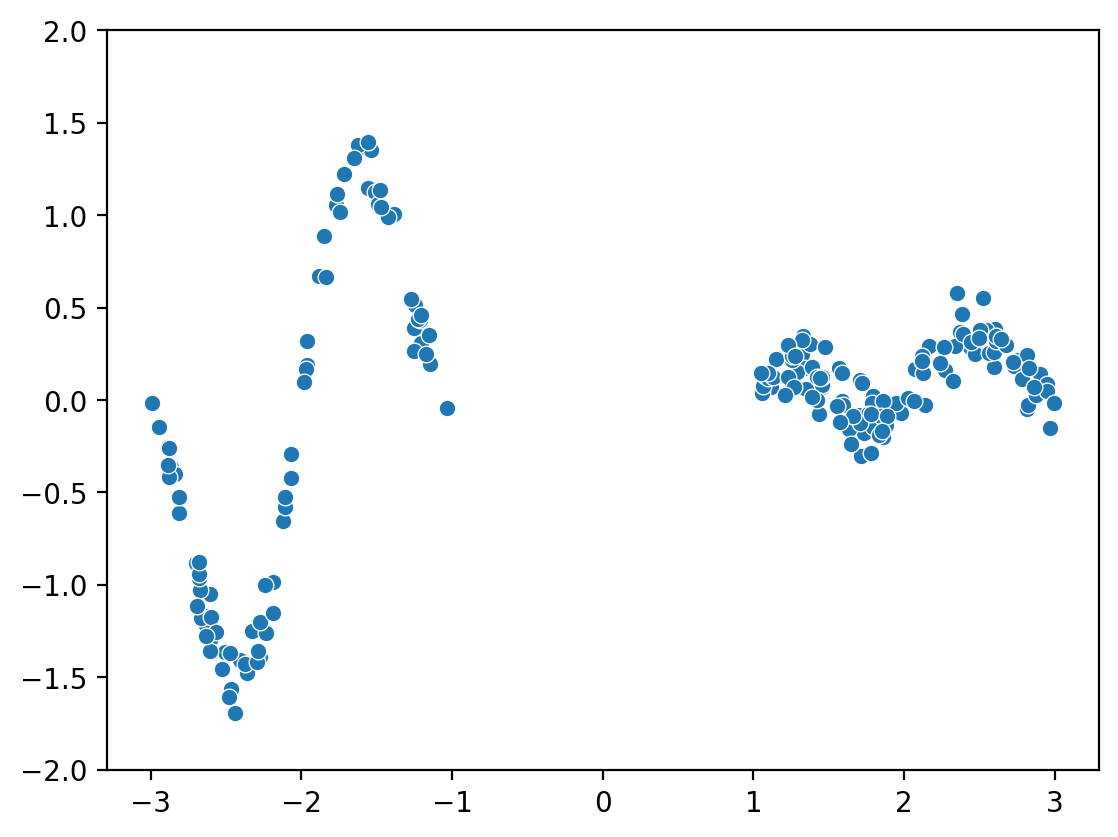

In [178]:
fig, ax = plt.subplots()
ax = sns.scatterplot(x=X, y=y, ax=ax)
ax.set_ylim(-2., 2.);

In [180]:
# Set up MLP
n_features = 20

features = [n_features] * 2 + [2,]
model = models.MLP(features=features)
params = model.init(jr.PRNGKey(0), jnp.ones((1,)))

flat_params, unflatten_fn = ravel_pytree(params)
def apply(flat_params, x, model, unflatten_fn):
    return model.apply(unflatten_fn(flat_params), jnp.atleast_1d(x))[0]
apply_fn = partial(apply, model=model, unflatten_fn=unflatten_fn)
emission_mean_function = apply_fn
emission_cov_function =lambda w, x: obs_var * jnp.eye(1)

# Set up NF
nf_model = NF_MLP(n_layers=10)
input_dim = len(flat_params)
nfs = init_normalizing_flow(nf_model, input_dim)

## 2.1 Vanilla FCEKF (lr=0.0)

In [181]:
ekf = RebayesNFEKF(
    dynamics_weights_or_function=1.0,
    dynamics_covariance=0.,
    emission_mean_function=emission_mean_function,
    emission_cov_function=emission_cov_function,
    nf_initial_params=nfs["params"],
    nf_apply_function=nfs["apply_fn"],
    method="fcekf",
    learning_rate=0.0,
)

ekf_kwargs = {
    "agent": ekf,
    "test_set": X_grid,
}

def callback(bel, pred_obs, t, x, y, bel_pred, **kwargs):
    agent = kwargs["agent"]
    grid = kwargs["test_set"]
    y_mean = vmap(agent.predict_obs, (None, 0))(bel_pred, grid)
    y_cov = vmap(agent.predict_obs_cov, (None, 0))(bel_pred, grid)
    log_prob = agent.evaluate_log_prob(bel, x, y)
    
    return y_mean, y_cov, log_prob

init_cov = 1e-1

ekf_bel, ekf_outputs = ekf.scan(
    flat_params, init_cov, X, y, callback=callback, **ekf_kwargs
)

In [138]:
pred_means, pred_covs, log_probs = ekf_outputs
pred_stds = jnp.sqrt(pred_covs)
pred_mean, pred_std = pred_means[-1].ravel(), pred_stds[-1].ravel()

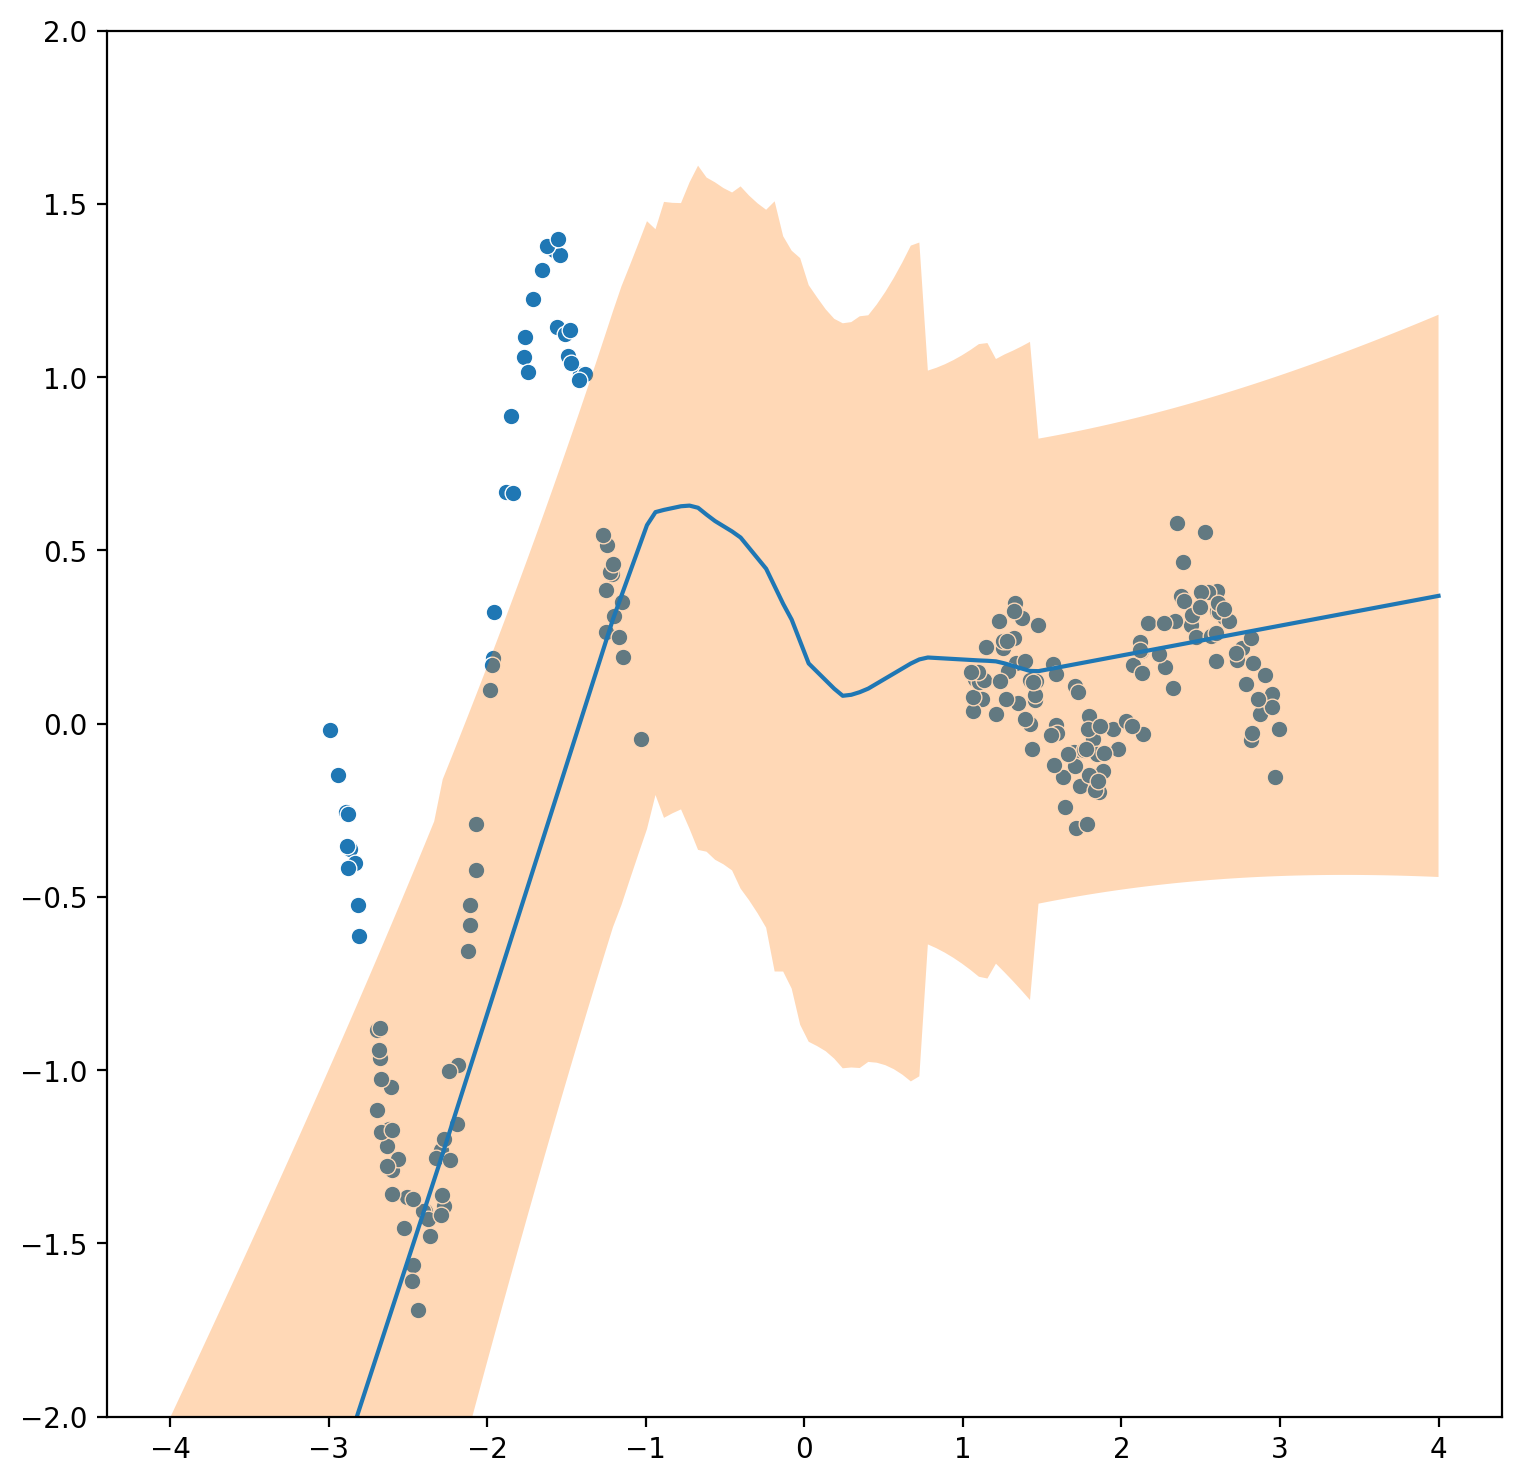

In [139]:
# Visualize the uncertainty results
fig, ax = plt.subplots(figsize=(9, 9))
ax = sns.scatterplot(x=X, y=y, ax=ax)
ax = sns.lineplot(x=X_grid, y=pred_mean, ax=ax)
ax.fill_between(
    X_grid, pred_mean - 1.96*pred_std, pred_mean + 1.96*pred_std, alpha=0.3
)
ax.set_ylim(-2., 2.);

## 2.2 NF-FCEKF

In [161]:
import jax

ekf = RebayesNFEKF(
    dynamics_weights_or_function=1.0,
    dynamics_covariance=0.,
    emission_mean_function=emission_mean_function,
    emission_cov_function=emission_cov_function,
    nf_initial_params=nfs["params"],
    nf_apply_function=nfs["apply_fn"],
    method="fcekf",
    learning_rate=1e-4,
)

ekf_kwargs = {
    "agent": ekf,
    "test_set": X_grid,
}

def callback(bel, pred_obs, t, x, y, bel_pred, **kwargs):
    agent = kwargs["agent"]
    grid = kwargs["test_set"]
    y_mean = vmap(agent.predict_obs, (None, 0))(bel_pred, grid)
    y_cov = vmap(agent.predict_obs_cov, (None, 0))(bel_pred, grid)
    log_prob = agent.evaluate_log_prob(bel, x, y)
    
    return y_mean, y_cov, log_prob

init_cov = 1e-1

ekf_bel, ekf_outputs = ekf.scan(
    flat_params, init_cov, X, y, callback=callback, **ekf_kwargs
)

In [160]:
pred_means, pred_covs, log_probs = ekf_outputs
pred_stds = jnp.sqrt(pred_covs)
pred_mean, pred_std = pred_means[-1].ravel(), pred_stds[-1].ravel()

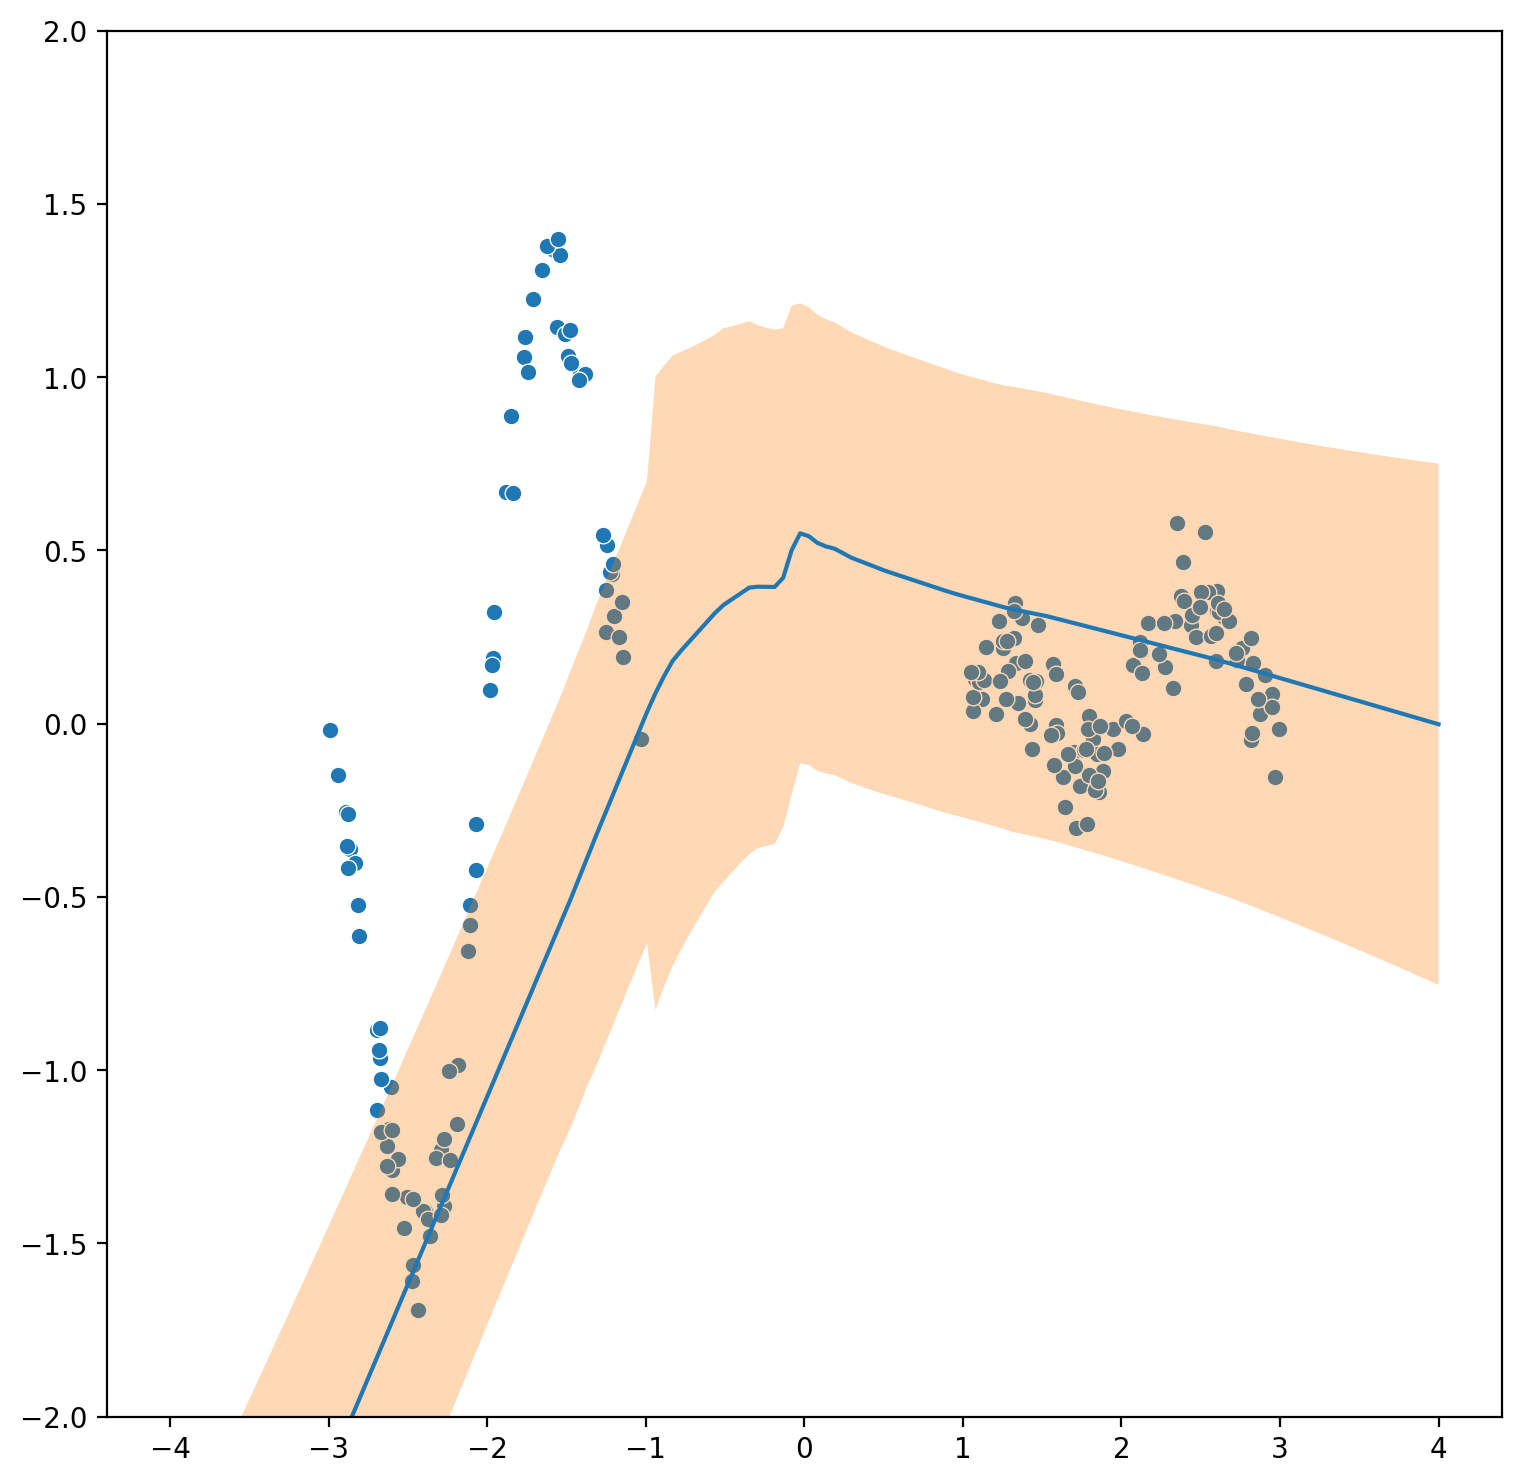

In [157]:
# Visualize the uncertainty results
fig, ax = plt.subplots(figsize=(9, 9))
ax = sns.scatterplot(x=X, y=y, ax=ax)
ax = sns.lineplot(x=X_grid, y=pred_mean, ax=ax)
ax.fill_between(
    X_grid, pred_mean - 1.96*pred_std, pred_mean + 1.96*pred_std, alpha=0.3
)
ax.set_ylim(-2., 2.);

## 2.3 NF-VDEKF

In [169]:
# Set up MLP
n_features = 100

features = [n_features] * 3 + [2,]
model = models.MLP(features=features)
params = model.init(jr.PRNGKey(0), jnp.ones((1,)))

flat_params, unflatten_fn = ravel_pytree(params)
def apply(flat_params, x, model, unflatten_fn):
    return model.apply(unflatten_fn(flat_params), jnp.atleast_1d(x))[0]
apply_fn = partial(apply, model=model, unflatten_fn=unflatten_fn)
emission_mean_function = apply_fn
emission_cov_function =lambda w, x: obs_var * jnp.eye(1)

# Set up NF
nf_model = NF_MLP()
input_dim = len(flat_params)
nfs = init_normalizing_flow(nf_model, input_dim)

In [170]:
ekf = RebayesNFEKF(
    dynamics_weights_or_function=1.0,
    dynamics_covariance=0.,
    emission_mean_function=emission_mean_function,
    emission_cov_function=emission_cov_function,
    nf_initial_params=nfs["params"],
    nf_apply_function=nfs["apply_fn"],
    method="vdekf",
    learning_rate=0.0,
)

ekf_kwargs = {
    "agent": ekf,
    "test_set": X_grid,
}

def callback(bel, pred_obs, t, x, y, bel_pred, **kwargs):
    agent = kwargs["agent"]
    grid = kwargs["test_set"]
    y_mean = vmap(agent.predict_obs, (None, 0))(bel_pred, grid)
    y_cov = vmap(agent.predict_obs_cov, (None, 0))(bel_pred, grid)
    log_prob = agent.evaluate_log_prob(bel, x, y)
    
    return y_mean, y_cov, log_prob

init_cov = 1e-1

ekf_bel, ekf_outputs = ekf.scan(
    flat_params, init_cov, X, y, callback=callback, **ekf_kwargs
)

In [171]:
pred_means, pred_covs, log_probs = ekf_outputs
pred_stds = jnp.sqrt(pred_covs)
pred_mean, pred_std = pred_means[-1].ravel(), pred_stds[-1].ravel()

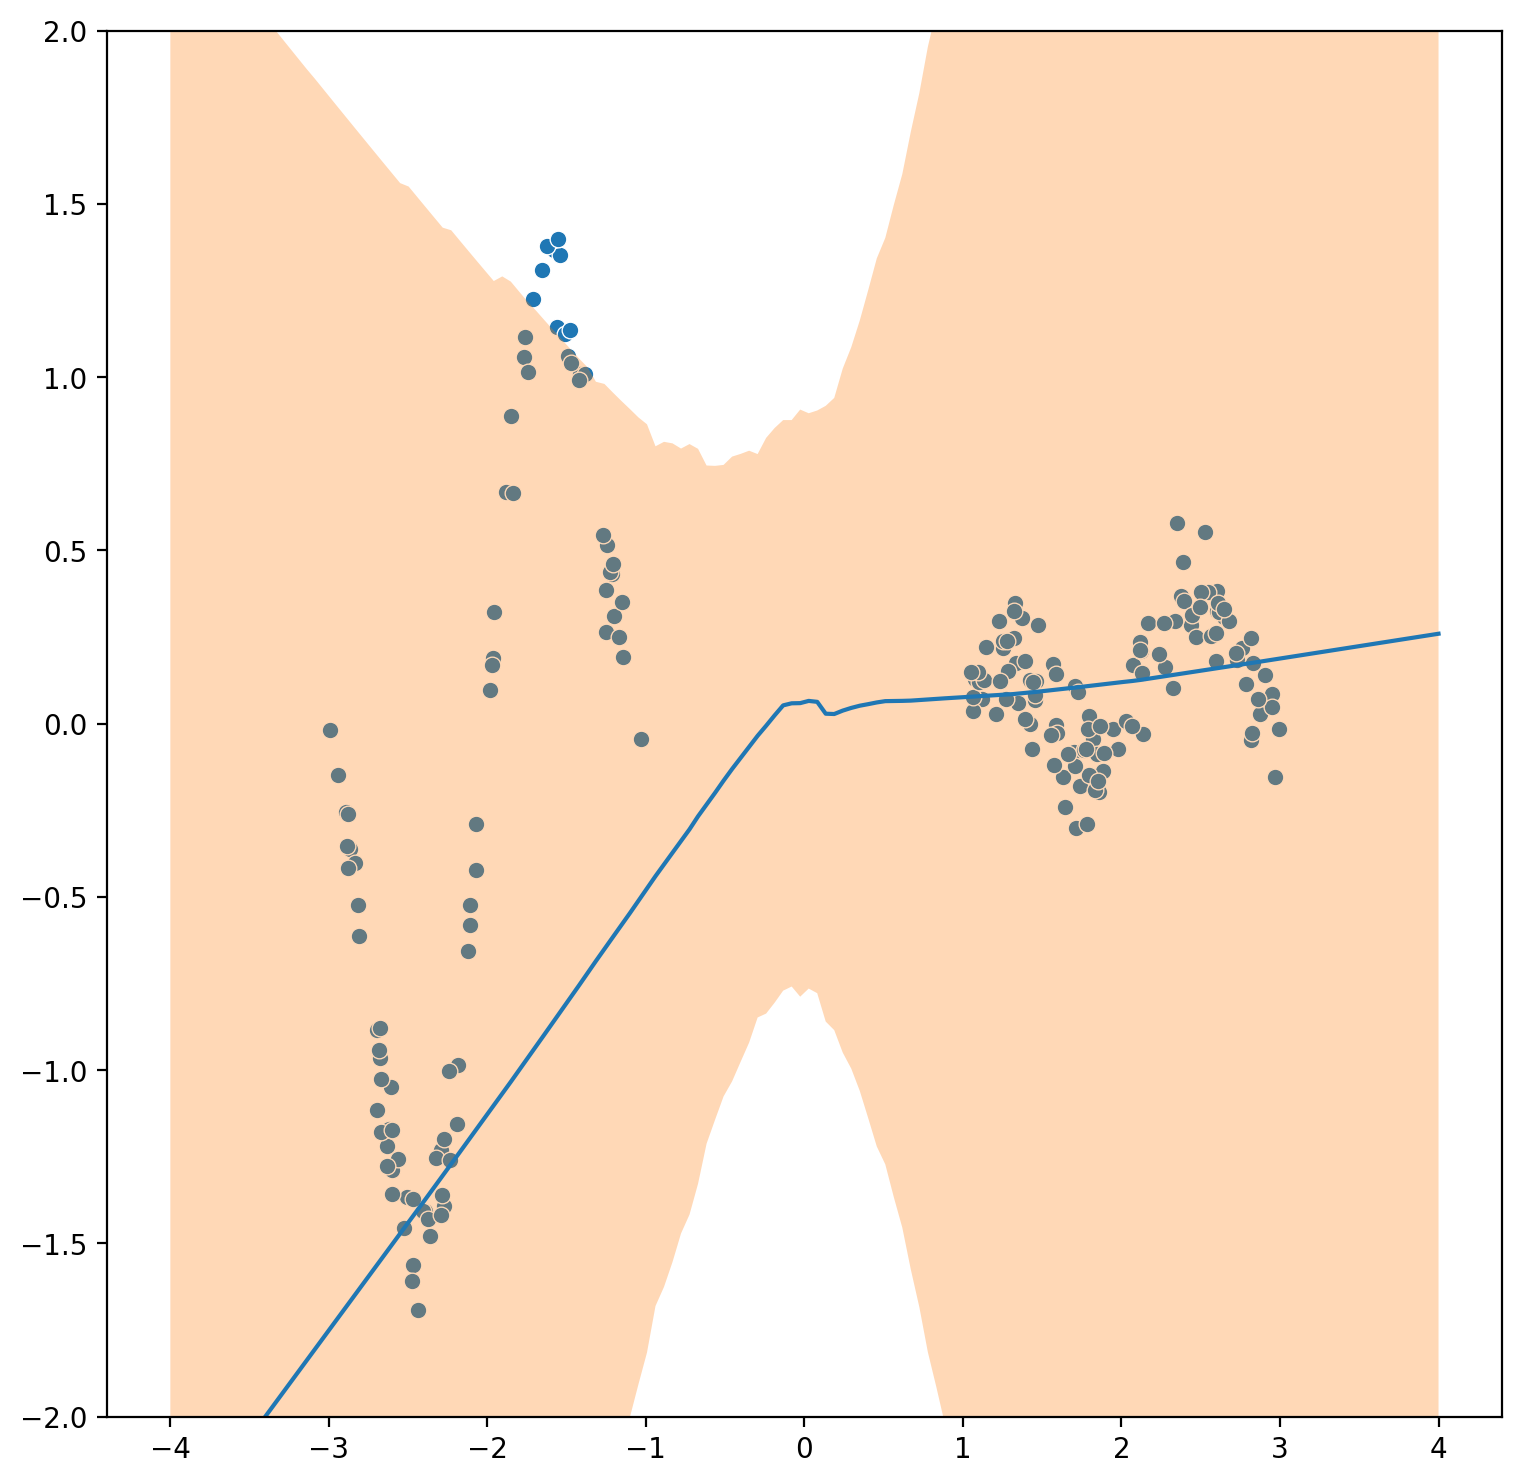

In [172]:
# Visualize the uncertainty results
fig, ax = plt.subplots(figsize=(9, 9))
ax = sns.scatterplot(x=X, y=y, ax=ax)
ax = sns.lineplot(x=X_grid, y=pred_mean, ax=ax)
ax.fill_between(
    X_grid, pred_mean - 1.96*pred_std, pred_mean + 1.96*pred_std, alpha=0.3
)
ax.set_ylim(-2., 2.);

In [173]:
ekf = RebayesNFEKF(
    dynamics_weights_or_function=1.0,
    dynamics_covariance=0.,
    emission_mean_function=emission_mean_function,
    emission_cov_function=emission_cov_function,
    nf_initial_params=nfs["params"],
    nf_apply_function=nfs["apply_fn"],
    method="vdekf",
    learning_rate=1e-4,
)

ekf_kwargs = {
    "agent": ekf,
    "test_set": X_grid,
}

def callback(bel, pred_obs, t, x, y, bel_pred, **kwargs):
    agent = kwargs["agent"]
    grid = kwargs["test_set"]
    y_mean = vmap(agent.predict_obs, (None, 0))(bel_pred, grid)
    y_cov = vmap(agent.predict_obs_cov, (None, 0))(bel_pred, grid)
    log_prob = agent.evaluate_log_prob(bel, x, y)
    
    return y_mean, y_cov, log_prob

init_cov = 1e-1

ekf_bel, ekf_outputs = ekf.scan(
    flat_params, init_cov, X, y, callback=callback, **ekf_kwargs
)

In [174]:
pred_means, pred_covs, log_probs = ekf_outputs
pred_stds = jnp.sqrt(pred_covs)
pred_mean, pred_std = pred_means[-1].ravel(), pred_stds[-1].ravel()

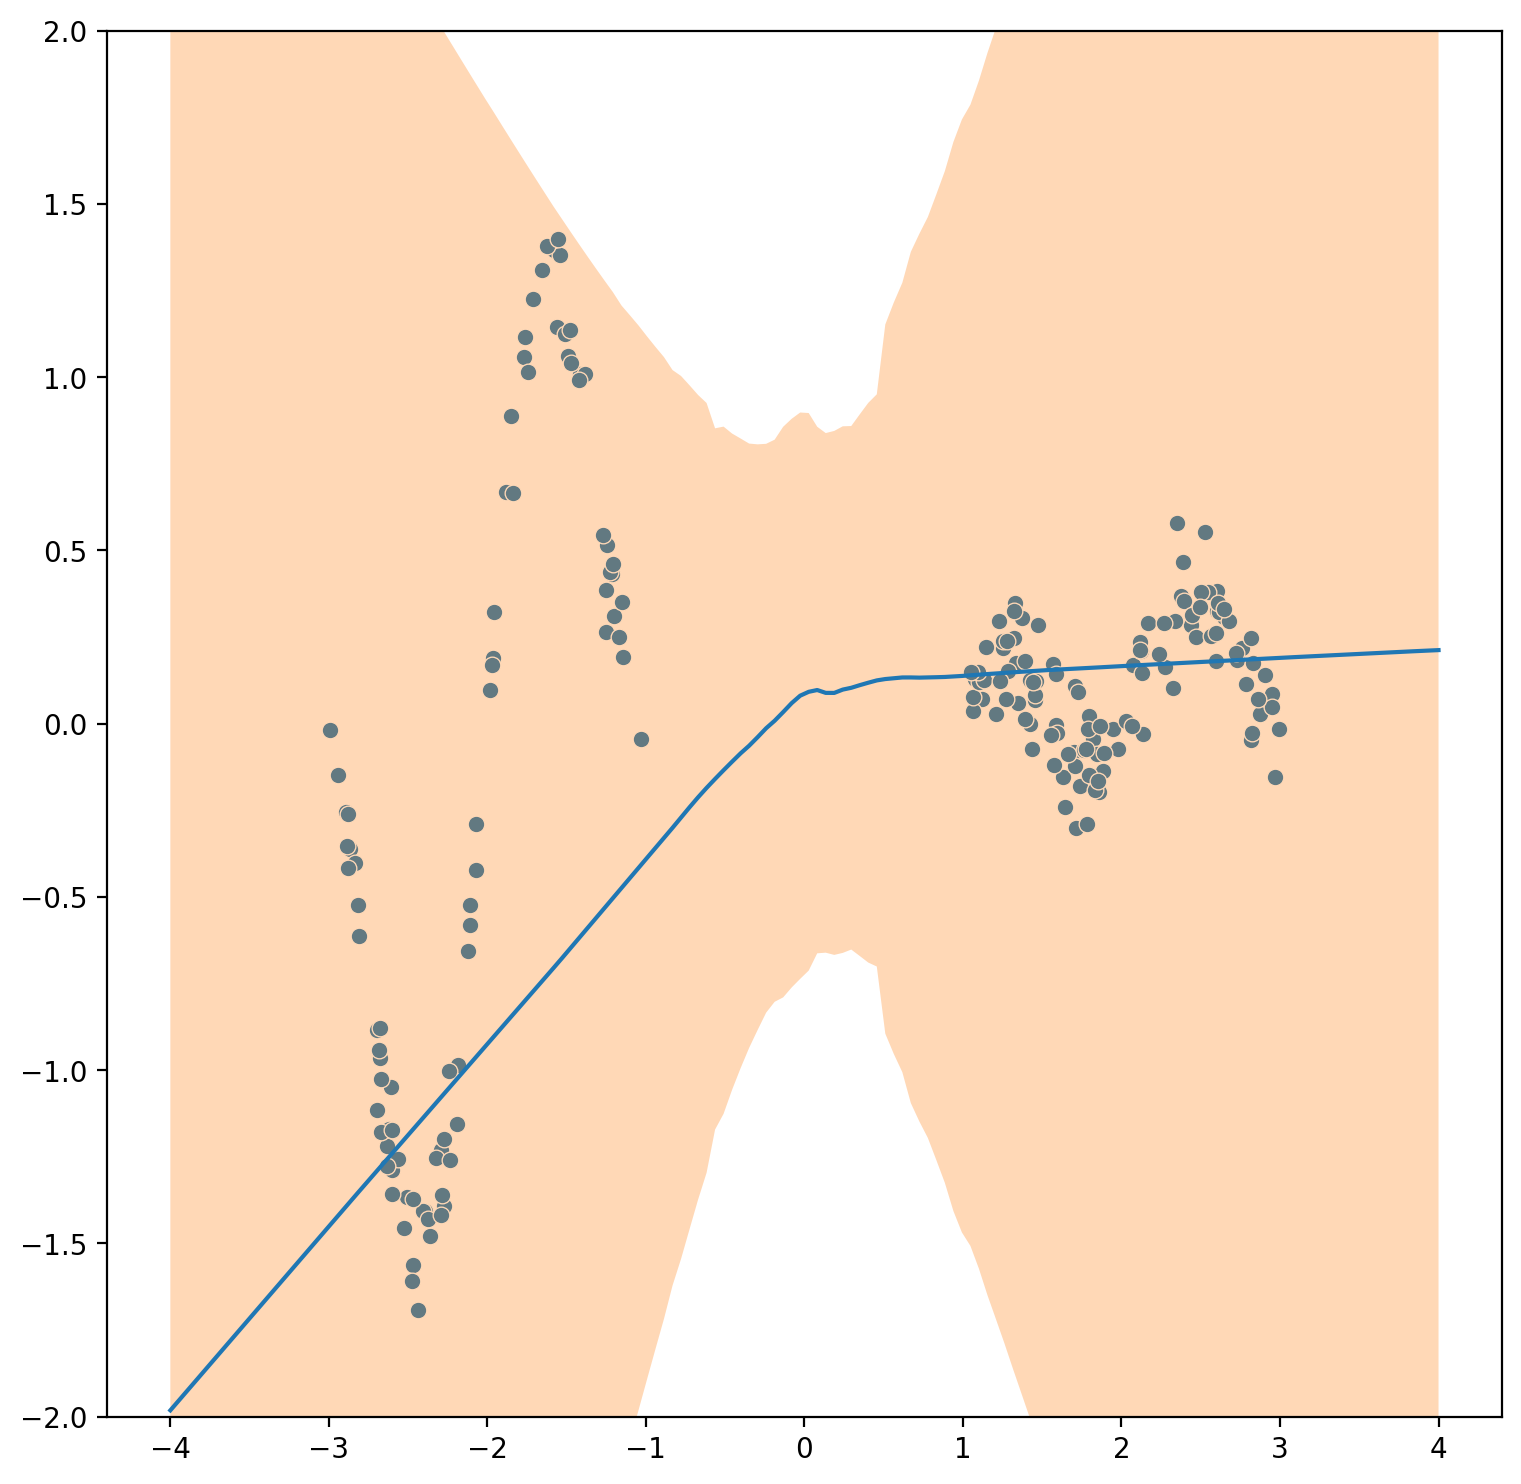

In [175]:
# Visualize the uncertainty results
fig, ax = plt.subplots(figsize=(9, 9))
ax = sns.scatterplot(x=X, y=y, ax=ax)
ax = sns.lineplot(x=X_grid, y=pred_mean, ax=ax)
ax.fill_between(
    X_grid, pred_mean - 1.96*pred_std, pred_mean + 1.96*pred_std, alpha=0.3
)
ax.set_ylim(-2., 2.);